In [1]:
from __future__ import annotations

# *Imas2xarray*

*Imas2xarray* is a library that makes it as simple and intuitive as possible to read and write IMAS data in HDF5 format with Python. There is no need to manually define the paths or fiddle with the different dimensions and long keys. To handle large datasets, *imas2xarray* uses [xarray](https://docs.xarray.dev) to store the data in a more managable format. 

Test data are available from [here](https://github.com/duqtools/hdf5_testdata/tree/main).

## Reading data

To get the data, we can use `to_xarray` and pass the data path, the ids, and the names of the variables we are interested in. Note that they must all belong to the same root IDS (`core_profiles` in this case). If you are using your own data, update the `path` variable below.

Many variables are pre-defined by `imas2xarray`. These variables define the relations between the data. For more information, see the [documentation on variables](https://imas2xarray.readthedocs.io/en/latest/variables/).

In [2]:
from imas2xarray import to_xarray

variables = 'zeff', 't_i_ave', 'rho_tor_norm', 'time'

path = './1/data'
ids = 'core_profiles'

ds = to_xarray(path, ids=ids, variables=variables)
print(ds)

<xarray.Dataset>
Dimensions:       (time: 1, rho_tor_norm: 101)
Coordinates:
  * time          (time) float64 50.04
  * rho_tor_norm  (rho_tor_norm) float64 0.0 0.01 0.02 0.03 ... 0.98 0.99 1.0
Data variables:
    zeff          (time, rho_tor_norm) float64 1.761 1.761 1.761 ... 1.761 1.761
    t_i_ave       (time, rho_tor_norm) float64 1.139e+04 1.139e+04 ... 559.2


## Writing data

Write data back to hdf5 using `to_imas`.

In [3]:
from imas2xarray import to_imas

ds['t_i_ave'] *= 1.1

to_imas(path, dataset=ds, ids=ids, variables=variables)

## Loading all variables

If you want to get all available pre-defined variables then you can leave out the variables.

In [4]:
ds2 = to_xarray(path, ids='core_profiles')
print(ds2)

<xarray.Dataset>
Dimensions:         (time: 1, rho_tor_norm: 101, ion: 4)
Coordinates:
  * time            (time) float64 50.04
  * rho_tor_norm    (rho_tor_norm) float64 0.0 0.01 0.02 0.03 ... 0.98 0.99 1.0
Dimensions without coordinates: ion
Data variables: (12/14)
    n_e             (time, rho_tor_norm) float64 7.976e+19 ... 1.742e+19
    n_e_tot         (time, rho_tor_norm) float64 7.976e+19 ... 1.742e+19
    p_i             (time, ion, rho_tor_norm) float64 1.242e+05 ... 0.2948
    zeff            (time, rho_tor_norm) float64 1.761 1.761 ... 1.761 1.761
    t_i_ave         (time, rho_tor_norm) float64 1.253e+04 1.253e+04 ... 615.1
    collisionality  (time, rho_tor_norm) float64 23.23 7.554 ... 7.31 10.19
    ...              ...
    j_tot           (time, rho_tor_norm) float64 -2.019e+06 ... -1.537e+05
    n_i             (time, ion, rho_tor_norm) float64 7.486e+19 ... 3.619e+15
    q               (time, rho_tor_norm) float64 0.7887 0.7888 ... 4.262 4.845
    omega_tor       (t

## Defining custom variables

To explain a bit better how variables work, we will define custom relations between the data in the next cell. You can use this to define your own variables which are not available in `imas2xarray`. Note that variable names and variable models can be mixed.

Define custom variables via the `Variable` model. 

This gives the name of the variable (user defined, can be anything), the IDS to grab it from, the path to the data, and the dimensions (all 3 part of the data spec). 

The special character `*` in the path denotes a dimension specified in the `dims` list. In this example, the `*` in the path refers to the first dimension defined in `dims`: `time`. In turn, `time` must also be defined as a `Variable`.

Variables like `zeff` and others use `rho_tor_norm` as the coordinate. But, unfortunately, `rho_tor_norm` differs slightly between time steps. Therefore we first assign this to a placeholder dimension by prefixing `$`: `$rho_tor_norm`. Imas2xarray knows to squash this dimension and make `rho_tor_norm` consistent for all time steps.

If you are interested to see what the data would look like without squashing, you can pass `squash=False` to `handle.get_variables()`.

In [5]:
from imas2xarray import Variable

variable_models = (
    Variable(
        name='zeff',
        ids='core_profiles',
        path='profiles_1d/*/zeff',
        dims=['time', '$rho_tor_norm'],
    ),
    Variable(
        name='t_i_ave',
        ids='core_profiles',
        path='profiles_1d/*/t_i_average',
        dims=['time', '$rho_tor_norm'],
    ),
    Variable(
        name='rho_tor_norm',
        ids='core_profiles',
        path='profiles_1d/*/grid/rho_tor_norm',
        dims=['time', '$rho_tor_norm'],
    ),
    Variable(name='time', ids='core_profiles', path='time', dims=['time']),
)

ds = to_xarray(path, ids=ids, variables=variable_models)
print(ds)

<xarray.Dataset>
Dimensions:       (time: 1, rho_tor_norm: 101)
Coordinates:
  * time          (time) float64 50.04
  * rho_tor_norm  (rho_tor_norm) float64 0.0 0.01 0.02 0.03 ... 0.98 0.99 1.0
Data variables:
    zeff          (time, rho_tor_norm) float64 1.761 1.761 1.761 ... 1.761 1.761
    t_i_ave       (time, rho_tor_norm) float64 1.253e+04 1.253e+04 ... 615.1


## Standardize grid and time

IMAS data may not be on the same grid (i.e. x-values do not correspond between data sets) or use the same time steps. Therefore, the data must be standardized to the same set of reference coordinates so that the grid and time stamps correspond between different data sets. Because this is such a common operation, *imas2xarray* has helper functions to deal with these special cases. `rebase_on_grid` helps to rebase on the grid, and `rebase_on_time` to rebase on the time stamps. `standardize_grid_and_time` combines these two functions and can make a sequence of datasets consistent.

In [6]:
from imas2xarray import standardize_grid_and_time

paths = (
    './1/data/',
    './2/data/',
    './3/data/',
)

variables = 'zeff', 't_i_ave', 'rho_tor_norm', 'time'

datasets = [to_xarray(path, ids=ids, variables=variables) for path in paths]

datasets = standardize_grid_and_time(
    datasets,
    grid_var='rho_tor_norm',
    time_var='time',
    reference_dataset=0,
)

### Grid rebasing

Alternatively, you may standardize the grid for each dataset separately using `rebase_on_grid()`. In this way you can explicitly give the reference grid you want to interpolate to.

Note that this `standardize_grid_and_time()` already performs this step.

In [7]:
from imas2xarray import rebase_on_grid

datasets2 = [to_xarray(path, ids=ids, variables=variables) for path in paths]

reference_grid = datasets2[0]['rho_tor_norm'].data

datasets2 = [
    rebase_on_grid(ds, coord_dim='rho_tor_norm', new_coords=reference_grid) for ds in datasets2
]

### Time Standardizing

Sometimes we have datasets with various starting times, but we want to compare them anyway
for this you can use the `rezero_time()` function, which is an in-place operation:

In [8]:
from imas2xarray import rezero_time

for ds in datasets2:
    rezero_time(ds, start=0.1)

## Time rebasing

We can do the same for the time coordinate using `rebase_on_time()`. Note that this `standardize_grid_and_time()` already performs this step.

For example, if your reference data set has timestamps `(1.0, 2.0, 3.0, 4.0)`, and another `(1.0, 3.0, 5.0)`. The data in the second dataset will be interpolated to match the timestamps of the reference. 

If you know your data have the same time stamps, for example if they are from the same set of simulations, you can skip this step.

In [9]:
from imas2xarray import rebase_on_time

reference_time = datasets2[0]['time'].data

datasets2 = [rebase_on_time(ds, time_dim='time', new_coords=reference_time) for ds in datasets2]

## Data concatenation

Finally, we can concatenate along the run dimension. We set the run coordinates to the name of the data so they can be re-used later.

In [10]:
import xarray as xr

dataset = xr.concat(datasets, 'run')
dataset['run'] = [f'run_{i}' for i in range(len(paths))]

Now we have the data in a nicely structured xarray dataset.

In [11]:
print(dataset)

<xarray.Dataset>
Dimensions:       (run: 3, time: 1, rho_tor_norm: 101)
Coordinates:
  * time          (time) float64 50.04
  * rho_tor_norm  (rho_tor_norm) float64 0.0 0.01 0.02 0.03 ... 0.98 0.99 1.0
  * run           (run) <U5 'run_0' 'run_1' 'run_2'
Data variables:
    zeff          (run, time, rho_tor_norm) float64 1.761 1.761 ... 1.761 1.761
    t_i_ave       (run, time, rho_tor_norm) float64 1.253e+04 ... 711.7


## Plotting

Now that we have standardized and rebased the grid and time coordinates, plotting and other operations on the data becomes straightforward. 

`xarray` has some built-in functionality to make plots using [matplotlib](https://matplotlib.org).

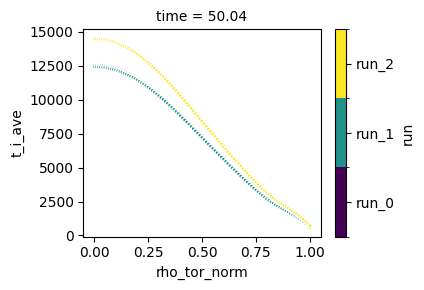

In [12]:
dataset.isel(time=[0]).plot.scatter(
    x='rho_tor_norm', y='t_i_ave', hue='run', col='time', marker='.'
);

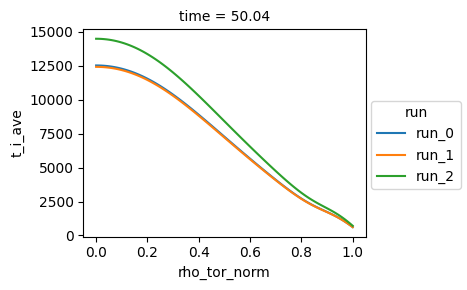

In [13]:
dataset['t_i_ave'].isel(time=[0]).plot.line(
    x='rho_tor_norm',
    hue='run',
    col='time',
);

## Data reduction

To reduce the data along some dimension, we can use `dataset.reduce()`. This method takes a function as the first argument, and will apply it for each slice in the given dimension. `xarray` has some shortcuts for common operators, so `dataset.reduce(np.mean, dim='run')` is equivalent to `dataset.mean(dim='run')`.

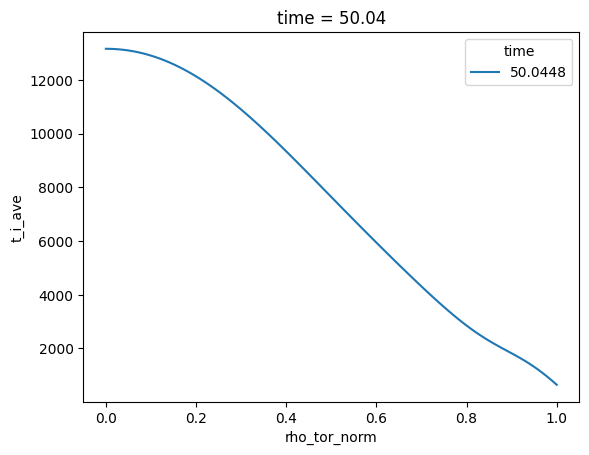

In [14]:
mean = dataset.mean(dim='run')

mean['t_i_ave'].isel(time=[0]).plot.line(
    x='rho_tor_norm',
    hue='time',
);